In [1]:
import codecarbon
from sklearn.datasets import make_classification

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
model_names = ["Logistic Regression", "SVM", "Random Forest", "MLP"]
models = [LogisticRegression(), SVC(), RandomForestClassifier(), MLPClassifier()]

In [3]:
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
import mlflow
emissions = []
accuracies = []

for model_name, model in zip(model_names, models):
    print(f"Training {model_name}...")
    with mlflow.start_run(run_name=model_name):
        tracker = codecarbon.EmissionsTracker(save_to_file=False, log_level="critical")
        tracker.start()
        model.fit(X_train, y_train)
        emission = tracker.stop() * 1000
        emissions.append(emission)
        #log model
        mlflow.sklearn.log_model(model, model_name)
        mlflow.log_metric("Emissions", emission)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        mlflow.log_metric("Accuracy", accuracy)


Training Logistic Regression...


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



Training SVM...


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



Training Random Forest...


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



Training MLP...


/Users/camille.hascoet/Documents/greenai/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



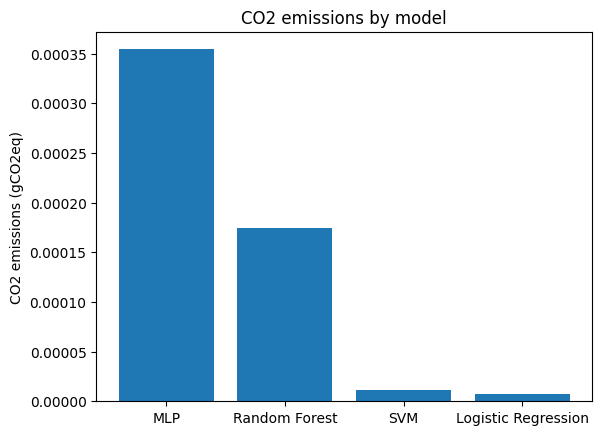

In [ ]:
df = pd.DataFrame(
    {"Model": model_names, "Emissions": emissions, "Accuracy": accuracies}
)
df = df.sort_values("Emissions", ascending=False)
plt.bar(df["Model"], df["Emissions"])
plt.ylabel("CO2 emissions (gCO2eq)")
plt.title("CO2 emissions by model")
plt.show()

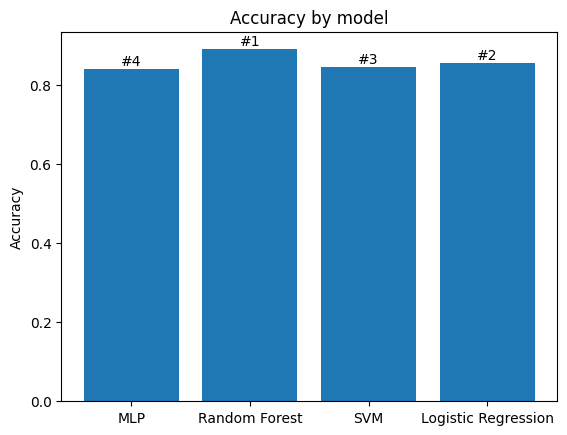

In [ ]:
# barplot of accuracies
plt.bar(df["Model"], df["Accuracy"])
plt.ylabel("Accuracy")
plt.title("Accuracy by model")
# write the rank on the bars
accuracies = -df["Accuracy"].values
ranking = accuracies.argsort().argsort() + 1


for i, v in enumerate(df["Accuracy"]):
    plt.text(i, v + 0.01, f"#{int(ranking[i])}", ha="center")
plt.show()

In [ ]:
print(df)

                 Model  Emissions  Accuracy
3                  MLP   0.000354     0.840
2        Random Forest   0.000175     0.890
1                  SVM   0.000011     0.845
0  Logistic Regression   0.000007     0.855


In [8]:
import torch
import typing
from typing import List

In [15]:
class Net(torch.nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_sizes: List[int]):
        super(Net, self).__init__()
        self.hidden_layers = torch.nn.ModuleList()
        self.hidden_layers.append(torch.nn.Linear(input_size, hidden_sizes[0]))
        for i in range(1, len(hidden_sizes)):
            self.hidden_layers.append(
                torch.nn.Linear(hidden_sizes[i - 1], hidden_sizes[i])
            )
        self.output = torch.nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        x = torch.sigmoid(self.output(x))
        return x

In [27]:
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [38]:
def train(model, X_train, y_train, epochs=25, lr=0.01, mlflow_run_name="MLP", mlflow_run_id = 0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCELoss()
    emissions = []
    with mlflow.start_run(run_name=mlflow_run_name):
        for epoch in range(epochs):
            
            tracker = codecarbon.EmissionsTracker(save_to_file=False, log_level="critical")
            tracker.start()
            optimizer.zero_grad()
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            emission = tracker.stop() * 1000
            emissions.append(emission + emissions[-1] if len(emissions) > 1 else emission)
            mlflow.log_metric('emission', emissions[-1], step=epoch)

        print(f"Training done")
        #log model params
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("lr", lr)
        mlflow.log_param("hidden_sizes", [layer.out_features for layer in model.hidden_layers])
        mlflow.log_param("input_size", model.hidden_layers[0].in_features)
        mlflow.log_param("output_size", model.output.out_features)
        mlflow.log_metric('Num of parameters', sum(p.numel() for p in model.parameters()))

        #log accuracy and inference emissions

        tracker = codecarbon.EmissionsTracker(save_to_file=False, log_level="critical")
        y_pred = model(X_test_torch)
        y_pred = (y_pred > 0.5).float()
        accuracy = torch.sum(y_pred == y_test_torch) / len(y_test)
        mlflow.log_metric("Accuracy", accuracy)

        tracker.start()
        for _ in range(5):
            y_pred = model(X_test_torch)
            y_pred = (y_pred > 0.5).float()

        inference_emission = tracker.stop() * 1000 / (5 * len(y_test))

        mlflow.log_metric("Inference Emissions per 1000 samples", inference_emission)

        print(f"Timing done")


    return emissions

In [39]:
model_1 = Net(input_size=20, output_size=1, hidden_sizes=[40, 20, 10])
model_2 = Net(input_size=20, output_size=1, hidden_sizes=[100, 50, 25])
model_3 = Net(input_size=20, output_size=1, hidden_sizes=[500, 250, 125])
model_4 = Net(input_size=20, output_size=1, hidden_sizes=[1000, 500, 250])

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

In [40]:
emissions_1 = train(model_1, X_train_torch, y_train_torch, mlflow_run_name="MLP_1", mlflow_run_id=1)
emissions_2 = train(model_2, X_train_torch, y_train_torch, mlflow_run_name="MLP_2", mlflow_run_id=2)
emissions_3 = train(model_3, X_train_torch, y_train_torch, mlflow_run_name="MLP_3", mlflow_run_id=3)
emissions_4 = train(model_4, X_train_torch, y_train_torch, mlflow_run_name="MLP_4", mlflow_run_id=4)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_i

Training done


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



Timing done


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_i

Training done


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



Timing done


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_i

Training done


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



Timing done


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_i

Training done


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



Timing done


ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)



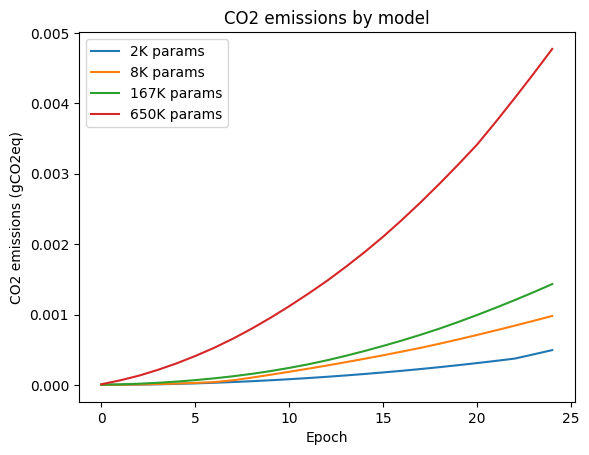

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_intel_driver_EnergyDriver)

ERROR: Failed to find the Power Gadget driver (com_i

In [41]:
plt.plot(np.cumsum(emissions_1), label="2K params")
plt.plot(np.cumsum(emissions_2), label="8K params")
plt.plot(np.cumsum(emissions_3), label="167K params")
plt.plot(np.cumsum(emissions_4), label="650K params")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("CO2 emissions (gCO2eq)")
plt.title("CO2 emissions by model")

plt.show()